Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

Esthetic definitions for the plots

In [2]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Common settings for cosmological parameters and other CLASS parameters

In [3]:
common_settings = {
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
}

# Obtaining the power spectra

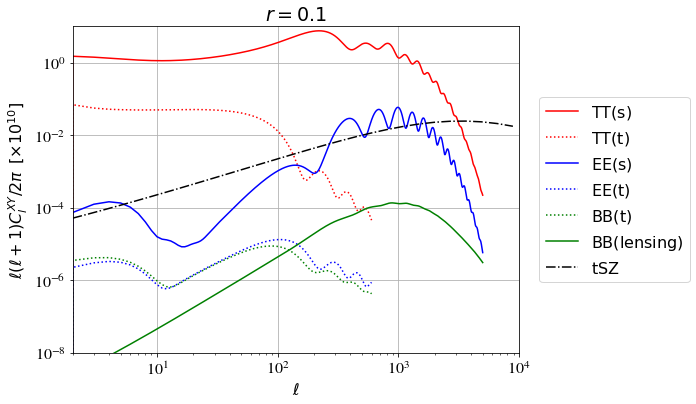

In [4]:


###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':5000})
M.compute()
cls = M.raw_cl(5000)
M.struct_cleanup()
M.empty()
#
# tensors only
#
M = Class()
M.set(common_settings)
l_max_tensors = 600
M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':l_max_tensors})
M.compute()
clt = M.raw_cl(l_max_tensors)
M.struct_cleanup()
M.empty()
#
# scalars + tensors (only in this case we can get the correct lensed ClBB)
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_s':0.9619,'n_t':0,'l_max_scalars':5000,'l_max_tensors':l_max_tensors})
M.compute()
cl_tot = M.raw_cl(5000)
cl_lensed = M.lensed_cl(5000)
M.struct_cleanup()
M.empty()


M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h',
       #'pressure profile': 'A10', 
       'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_sz = M.cl_sz()
M.struct_cleanup()
M.empty()

#
#################
#
# start plotting
#
#################
#
plt.xlim([2,10000])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cl_tot['ell']
ellt = clt['ell']
factor = 1.e10*ell*(ell+1.)/2./math.pi
factort = 1.e10*ellt*(ellt+1.)/2./math.pi
factor_sz = 1e-2
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-cl_tot['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),'k-.',label=r'$\mathrm{tSZ}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# Computing yxg

In [9]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_yg = M.cl_yg()
M.struct_cleanup()
M.empty()

[]

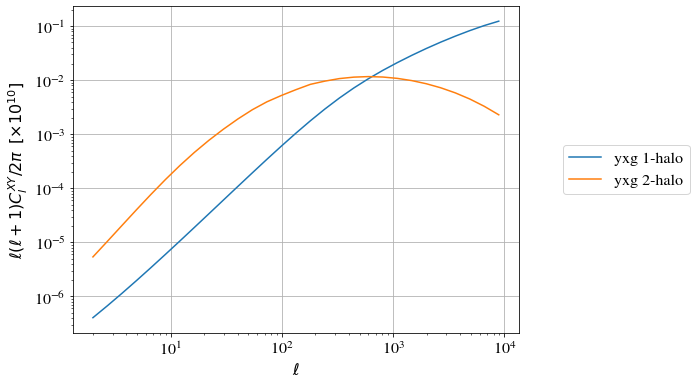

In [11]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_yg['ell'],cl_yg['1h'],label='yxg 1-halo')
plt.plot(cl_yg['ell'],cl_yg['2h'],label='yxg 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Obtaining the mass function

In [5]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
})
M.compute()


In [6]:
z = 1.
m = 1e13
M.get_dndlnM_at_z_and_M(z,m)

0.00020002187826449513

In [7]:
M.struct_cleanup()
M.empty()

# Obtaining $\sigma(M,z)$

In [8]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
})
M.compute()

In [9]:
z = 1.
m = 1e13
M.get_sigma_at_z_and_m(z,m)

0.9297578745284404

In [10]:
M.struct_cleanup()
M.empty()

# Obtaining $\nu(M,z)$
with $\nu = (\delta_\mathrm{crit}/\sigma)^2$ -- Note that in Tinker et al $\nu=\delta_\mathrm{crit}/\sigma$.

In [11]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
})
M.compute()

In [12]:
z = 1.
m = 1e13
M.get_nu_at_z_and_m(z,m)

3.2902807794759847

In [13]:
M.struct_cleanup()
M.empty()

# Obtaining linear bias $b$ and second order bias $b_2$


In [14]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
    'mass function' : 'T10'
})
M.compute()

In [15]:
z = 0.
nu = 2.
b1 = M.get_first_order_bias_at_z_and_nu(z,nu)
b2 = M.get_second_order_bias_at_z_and_nu(z,nu)
print('b1 = %.3f, b2 = %.3f'%(b1,b2))

b1 = 1.423, b2 = -0.577


In [16]:
nz = 10
nm = 100
z_arr = np.linspace(0.001,3.,nz)
m_arr = np.geomspace(1e11,5e15,nm)
nu_arr = np.zeros((nz,nm))
b1_arr = np.zeros((nz,nm))
b2_arr = np.zeros((nz,nm))
for iz,z in enumerate(z_arr):
    for im,m in enumerate(m_arr):
        nu_arr[iz][im] = M.get_nu_at_z_and_m(z,m) 
        b1_arr[iz][im] = M.get_first_order_bias_at_z_and_nu(z,nu_arr[iz][im])
        b2_arr[iz][im] = M.get_second_order_bias_at_z_and_nu(z,nu_arr[iz][im])
        


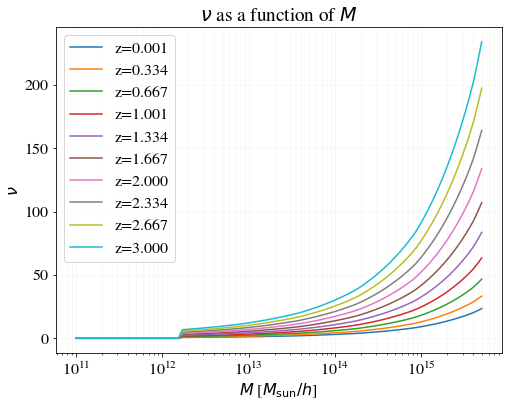

In [17]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,nu_arr[iz],label='z=%.3f'%z)
plt.xscale('log')
plt.legend(loc=2)
plt.title(r'$\nu$ as a function of $M$')
plt.ylabel(r'$\nu$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)

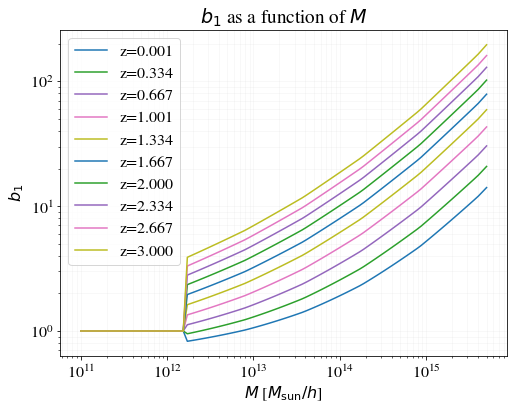

In [18]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,b1_arr[iz],label='z=%.3f'%z)
    plt.plot(m_arr,-b1_arr[iz],ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$b_1$ as a function of $M$')
plt.ylabel(r'$b_1$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)

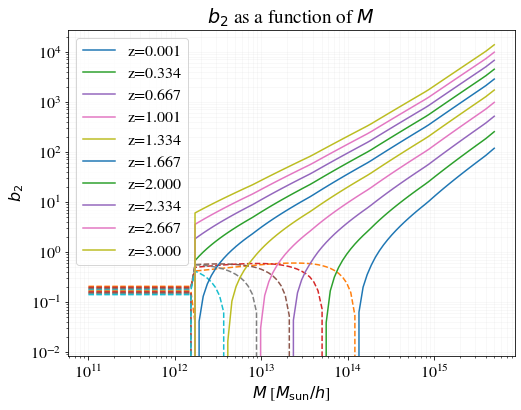

In [19]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,b2_arr[iz],label='z=%.3f'%z)
    plt.plot(m_arr,-b2_arr[iz],ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$b_2$ as a function of $M$')
plt.ylabel(r'$b_2$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)